# Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn
# Курсовой Проект Ершова Андрея Александровича

In [2]:
import warnings

warnings.filterwarnings('ignore')

In [94]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler, LabelEncoder
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import utils

%matplotlib inline

pd.options.display.max_columns = 100

In [4]:
TRAIN_MODEL_PATH = './train.csv'
TEST_MODEL_PATH = './test.csv'

In [5]:
train = pd.read_csv(TRAIN_MODEL_PATH)
test = pd.read_csv(TEST_MODEL_PATH)

###### Описание датасета:

$Id$ : идентификационный номер квартиры
<br>
$DistrictId$ : идентификационный номер района
<br>
$Rooms$ : количество комнат
<br>
$Square$ : площадь
<br>
$LifeSquare$ : жилая площадь
<br>
$KitchenSquare$ : площадь кухни
<br>
$Floor$ : этаж
<br>
$HouseFloor$ : количество этажей в доме
<br>
$HouseYear$ : год постройки дома
<br>
$Ecology\_1, Ecology\_2, Ecology\_3$ : экологические показатели местности
<br>
$Social\_1, Social\_2, Social\_3$ : социальные показатели местности
<br>
$Healthcare\_1, Helthcare\_2$ : показатели местности, связанные с охраной здоровья
<br>
$Shops\_1, Shops\_2$ : показатели, связанные с наличием магазинов, торговых центров
<br>
$Price$ : цена квартиры

In [6]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Библиотечные функции

In [14]:
def getStatisticsByColumn(d_frame, columnName, sortName='Count', asc=True):
    group = d_frame.groupby(columnName)
    df_stat = pd.DataFrame(group.apply(lambda x: x[columnName].unique()[0]))
    df_stat.columns = [columnName]
    df_stat.loc[:,'Count'] = group.apply(lambda x: x[columnName].count())
    df_stat.reset_index(inplace=True, drop=True)
    return df_stat.sort_values(by=sortName, axis=0, ascending=asc)

In [15]:
def fillEmptyObservationsByMedian(d_frame, columnName):
    mdn = d_frame[columnName].median()
    d_frame[columnName] = d_frame[columnName].fillna(mdn)
    return 0

In [16]:
def transformCategorialToBinary(d_frame, columnName):
    matching = filter(lambda column: columnName in column, d_frame.columns)

    if len(list(matching)) > 0:
        d_frame = pd.concat([d_frame, pd.get_dummies(d_frame[columnName], prefix=columnName)], axis=1)
        d_frame.drop(columnName, axis=1, inplace=True)
    return d_frame

In [17]:
def apply_elbow_method(d_frame):
    distortions = []
    K = range(2,15)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(d_frame)
        distortions.append(sum(np.min(cdist(d_frame, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / d_frame.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [18]:
def display_clusters_distribution(unique_labels, labels_counts):
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clгsters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [19]:
def reduce_dims_to_2D_space_with_PCA(d_frame):
    pca = PCA(n_components=2)
    components = pca.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_PCA(d_frame):
    pca = PCA(n_components=3)
    components = pca.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3'])

def reduce_dims_to_2D_space_with_TSNE(d_frame):
    tsne = TSNE(n_components=2, learning_rate=250, random_state=42)
    components = tsne.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2'])
    
def reduce_dims_to_3D_space_with_TSNE(d_frame):
    tsne = TSNE(n_components=3, learning_rate=250, random_state=42)
    components = tsne.fit_transform(d_frame)
    return pd.DataFrame(data = components, columns = ['component_1', 'component_2', 'component_3']) 

In [20]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mean_absolute_error(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mean_squared_error(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10)) 
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

## Тренировка модели

Нормализация поля $DistrictId$

In [21]:
print(getStatisticsByColumn(train, 'DistrictId')[:10])

     DistrictId  Count
204         209      1
202         207      1
201         205      1
117         117      1
197         199      1
196         196      1
174         174      1
200         202      2
203         208      2
195         195      2


In [22]:
train.loc[train.DistrictId == 0, 'DistrictId'] = train.DistrictId.median()

Нормализация поля $Rooms$

In [23]:
print(getStatisticsByColumn(train, 'Rooms')[:10])

   Rooms   Count
6    6.0     1.0
8   19.0     1.0
7   10.0     2.0
0    0.0     8.0
5    5.0    18.0
4    4.0   150.0
3    3.0  2235.0
1    1.0  3705.0
2    2.0  3880.0


In [24]:
train.Rooms = train.Rooms.astype(int)

In [25]:
print('средний метраж для однушек:   ', train.loc[train['Rooms'] == 1].median()['Square'])
print('средний метраж для двушек:    ', train.loc[train['Rooms'] == 2].median()['Square'])
print('средний метраж для трёшек:    ', train.loc[train['Rooms'] == 3].median()['Square'])
print('средний метраж для четвёрок:  ', train.loc[train['Rooms'] == 4].median()['Square'])
print('средний метраж для пятёрок:   ', train.loc[train['Rooms'] == 5].median()['Square'])
print('средний метраж для шестёрок:  ', train.loc[train['Rooms'] == 6].median()['Square'])

средний метраж для однушек:    40.40658991236909
средний метраж для двушек:     55.84181213903055
средний метраж для трёшек:     77.41364294803941
средний метраж для четвёрок:   98.66805357992513
средний метраж для пятёрок:    116.08486083443316
средний метраж для шестёрок:   59.41433379627719


Корректировка количества комнат на основании средних значений метража

In [26]:
train.loc[train.Id == 12638, 'Rooms'] = 5
train.loc[train.Id == 7917, 'Rooms'] = 10
train.loc[train.Id == 7317, 'Rooms'] = 1
train.loc[train.Id == 770, 'Rooms'] = 1
train.loc[train.Id == 456, 'Rooms'] = 3
train.loc[train.Id == 3159, 'Rooms'] = 1
train.loc[train.Id == 9443, 'Rooms'] = 3
train.loc[train.Id == 8491, 'Rooms'] = 1
train.loc[train.Id == 5927, 'Rooms'] = 2
train.loc[train.Id == 14865, 'Rooms'] = 1
train.loc[train.Id == 7594, 'Rooms'] = 1
train.loc[train.Id == 14003, 'Rooms'] = 2

In [31]:
train.loc[train.LifeSquare.isnull() == True]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74.0,2,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1.0,2,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
21,11935,27.0,2,64.711835,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
23,6641,54.0,3,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
25,5073,74.0,2,82.667915,NaN,1.0,16,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,244145.827069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27.0,1,38.968338,NaN,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.569405
9986,2996,1.0,2,64.994245,NaN,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.511658
9987,15623,23.0,2,55.620092,NaN,0.0,2,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.553006
9994,4158,23.0,2,64.864198,NaN,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515653


Нормализация поля $Square$

In [33]:
train.loc[(train.Square < 10)] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88.0,2,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27.0,1,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6.0,1,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27.0,1,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
3413,9487,5.0,1,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27.0,0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27.0,3,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1.0,1,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1.0,3,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34.0,1,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006


Невеверные значения, подлежащие удалению

In [35]:
train.drop(train[(train.Square < 10) & (train.Square < train.LifeSquare)].index, inplace=True)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Невеверные значения, подлежащие коррекции

In [36]:
train.loc[(train.Square < 10), 'Square'] = train.loc[(train.Square < 10), 'Square'] * 10
train.loc[(train.Square < 10), 'LifeSquare'] = train.loc[(train.Square < 10), 'LifeSquare'] * 10

Нормализация поля $LifeSquare$
<br>
<br>
Признак $LifeSquare$ имеeт высокую степень разряжения.
<br>
Заполняем отсутсвующие в этом столбце значения соотвествующими медианными значениями. 

In [38]:
fillEmptyObservationsByMedian(train, 'LifeSquare')

0

In [49]:
train.loc[(train.LifeSquare > 200)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1981,7917,27.0,10,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1982,5548,86.0,5,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
4690,2307,102.0,1,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
6977,11602,30.0,2,641.065193,638.163193,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
9910,16568,27.0,4,200.334539,201.627361,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B,528560.506016


Невеверные значения, подлежащие коррекции

In [41]:
train.loc[(train.LifeSquare < 10), 'LifeSquare'] = train.loc[(train.LifeSquare < 10), 'LifeSquare'] * 10
train.loc[(train.LifeSquare < 10), 'LifeSquare'] = train.loc[(train.LifeSquare < 10), 'LifeSquare'] * 10

In [46]:
train.loc[train.Id == 16550, 'LifeSquare'] = train.loc[train.Id == 16550, 'LifeSquare']/100
train.loc[train.Id == 14990, 'LifeSquare'] = train.loc[train.Id == 14990, 'LifeSquare']/10
train.loc[train.Id == 15886, 'LifeSquare'] = train.loc[train.Id == 15886, 'LifeSquare']/10

Нормализация поля $KitchenSquare$

In [52]:
train.loc[(train.KitchenSquare < 4)] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53.0,2,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
7,11993,74.0,2,80.312926,32.784434,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1.0,2,64.511437,32.784434,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
12,6452,13.0,2,54.522805,31.759753,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.372609
14,10953,27.0,1,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27.0,1,38.968338,32.784434,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.569405
9986,2996,1.0,2,64.994245,32.784434,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.511658
9987,15623,23.0,2,55.620092,32.784434,0.0,2,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.553006
9994,4158,23.0,2,64.864198,32.784434,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515653


Невеверные значения, подлежащие коррекции

In [54]:
train.loc[(train.KitchenSquare == 0), 'KitchenSquare'] = train.KitchenSquare.median()
train.loc[(train.KitchenSquare > train.LifeSquare), 'KitchenSquare'] = train.KitchenSquare.median()

Нормализация поля $Floor$

In [55]:
train.loc[(train.Floor > 30), 'Floor'] = train.Floor.median()

Нормализация поля $HouseFloor$

In [56]:
train.HouseFloor = train.HouseFloor.astype(int)

In [58]:
print(getStatisticsByColumn(train, 'HouseFloor', 'HouseFloor', False)[:10])

    HouseFloor  Count
43         117      1
42          99      2
41          48      2
40          47      1
39          45      1
38          44      1
37          40      7
36          39      2
35          38      1
34          37      4


In [59]:
train.loc[(train.HouseFloor > 30), 'HouseFloor'] = train.HouseFloor.median()

Нормализация поля $HouseYear$

In [60]:
print(getStatisticsByColumn(train, 'HouseYear')[:10])

    HouseYear  Count
0        1910      1
95       4968      1
22       1947      1
7        1928      1
96   20052011      1
3        1916      1
2        1914      1
1        1912      2
8        1929      2
11       1932      2


In [61]:
train.loc[(train.HouseYear == 20052011), 'HouseYear'] = 2005
train.loc[(train.HouseYear > 2020), 'HouseYear'] = train.HouseYear.median()

Нормализация поля $Ecology\_1$

In [62]:
print(getStatisticsByColumn(train, 'Ecology_1')[:10])

        Ecology_1  Count
21   1.433395e-02    1.0
18   1.252163e-02    1.0
121  3.940942e-01    2.0
15   1.131981e-02    3.0
120  3.867717e-01    6.0
23   1.458072e-02    7.0
105  2.466236e-01    9.0
1    1.800000e-09   10.0
49   5.181543e-02   11.0
9    4.949358e-03   11.0


Нормализация поля $Ecology\_2$
<br>
<br>
Преобразуем категориальный признак $Ecology\_2$ в несколько бинарных

In [63]:
train = transformCategorialToBinary(train, 'Ecology_2')
train.drop("Ecology_2_B", axis=1, inplace=True)

In [64]:
print(getStatisticsByColumn(train, 'Ecology_2_A')[:10])

   Ecology_2_A  Count
1            1     97
0            0   9893


Нормализация поля $Ecology\_3$
<br>
<br>
Преобразуем категориальный признак $Ecology\_3$ в несколько бинарных

In [65]:
train = transformCategorialToBinary(train, 'Ecology_3')
train.drop("Ecology_3_B", axis=1, inplace=True)

In [66]:
print(getStatisticsByColumn(train, 'Ecology_3_A')[:10])

   Ecology_3_A  Count
1            1    275
0            0   9715


Нормализация поля $Social\_1$

In [67]:
print(getStatisticsByColumn(train, 'Social_1', 'Social_1')[:10])

   Social_1  Count
0         0    201
1         1    652
2         2    688
3         3      9
4         4    141
5         5    527
6         6    377
7         7     15
8         8     62
9         9    211


Нормализация поля $Social\_2$

In [68]:
print(getStatisticsByColumn(train, 'Social_2', 'Social_2')[:10])

   Social_2  Count
0       168    190
1       186     11
2       264    585
3       290     11
4       388     56
5       469    142
6       475     55
7       507      1
8       528      1
9       568      3


Нормализация поля $Social\_3$

In [69]:
print(getStatisticsByColumn(train, 'Social_3', 'Social_3')[:10])

   Social_3  Count
0         0   2992
1         1   1861
2         2    634
3         3   1135
4         4    833
5         5    391
6         6    422
7         7    184
8         8    170
9         9    192


Нормализация поля $Healthcare\_1$
<br>
<br>
Признак $Healthcare\_1$ имеeт высокую степень разряжения.
<br>
Заполняем отсутсвующие в этом столбце значения соотвествующими медианными значениями. 

In [70]:
fillEmptyObservationsByMedian(train, 'Healthcare_1')

0

In [71]:
print(getStatisticsByColumn(train, 'Healthcare_1', 'Healthcare_1')[:10])

   Healthcare_1  Count
0           0.0    1.0
1          30.0  348.0
2          32.0   12.0
3          35.0    2.0
4          46.0   49.0
5          75.0   16.0
6          80.0   35.0
7         100.0   25.0
8         125.0  103.0
9         145.0   50.0


In [73]:
train.Healthcare_1 = train.Healthcare_1.astype(int)

Нормализация поля $Healthcare\_2$

In [74]:
train.rename(columns={"Helthcare_2": "Healthcare_2"}, inplace=True)

In [75]:
print(getStatisticsByColumn(train, 'Healthcare_2')[:10])

   Healthcare_2  Count
6             6     99
4             4    287
5             5    388
2             2   1158
3             3   1668
1             1   2182
0             0   4208


Нормализация поля $Shops\_1$

In [76]:
print(getStatisticsByColumn(train, 'Shops_1')[:10])

    Shops_1  Count
14       19     49
13       16     83
12       15    176
10       10    215
15       23    245
8         8    253
7         7    293
9         9    315
11       11    400
6         6    487


Нормализация поля $Shops\_2$
<br>
Преобразуем категориальный признак $Shops\_2$ в несколько бинарных

In [77]:
train = transformCategorialToBinary(train, 'Shops_2')
train.drop("Shops_2_B", axis=1, inplace=True)

In [79]:
print(getStatisticsByColumn(train, 'Shops_2_A')[:10])

   Shops_2_A  Count
1          1    825
0          0   9165


##### Сохранение и извлечение модели из файла (pickle формат) для более быстрой инициализации

In [80]:
train.reset_index(inplace=True, drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 20 columns):
Id               9990 non-null int64
DistrictId       9990 non-null float64
Rooms            9990 non-null int32
Square           9990 non-null float64
LifeSquare       9990 non-null float64
KitchenSquare    9990 non-null float64
Floor            9990 non-null float64
HouseFloor       9990 non-null float64
HouseYear        9990 non-null float64
Ecology_1        9990 non-null float64
Social_1         9990 non-null int64
Social_2         9990 non-null int64
Social_3         9990 non-null int64
Healthcare_1     9990 non-null int32
Healthcare_2     9990 non-null int64
Shops_1          9990 non-null int64
Price            9990 non-null float64
Ecology_2_A      9990 non-null uint8
Ecology_3_A      9990 non-null uint8
Shops_2_A        9990 non-null uint8
dtypes: float64(9), int32(2), int64(6), uint8(3)
memory usage: 1.2 MB


In [82]:
train.to_pickle("./dummy.pkl")

In [99]:
train = pd.read_pickle("./dummy.pkl")

## Анализ модели

In [107]:
target_mean = round(train.Price.mean(), 2)
target_median = train.Price.median()
target_mode = train.Price.mode()[0]

target_mean, target_median, target_mode

(214055.18, 192255.01789602835, 59174.77802758122)

In [109]:
feature_names = train.columns.tolist()[1:]
feature_names.remove('Price')

#### Оценка эффективности для всех признаков

In [159]:
X = train[feature_names]
y = train[['Price']]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 18 columns):
DistrictId       9990 non-null float64
Rooms            9990 non-null int32
Square           9990 non-null float64
LifeSquare       9990 non-null float64
KitchenSquare    9990 non-null float64
Floor            9990 non-null float64
HouseFloor       9990 non-null float64
HouseYear        9990 non-null float64
Ecology_1        9990 non-null float64
Social_1         9990 non-null int64
Social_2         9990 non-null int64
Social_3         9990 non-null int64
Healthcare_1     9990 non-null int32
Healthcare_2     9990 non-null int64
Shops_1          9990 non-null int64
Ecology_2_A      9990 non-null uint8
Ecology_3_A      9990 non-null uint8
Shops_2_A        9990 non-null uint8
dtypes: float64(8), int32(2), int64(5), uint8(3)
memory usage: 1.1 MB


In [160]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [161]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth=400, random_state=42)

#### Анализ важности признаков для разных алгоритмов

In [162]:
%%time

rfr = RandomForestRegressor(
    bootstrap=True, 
    max_depth=100, 
    max_features=4, 
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=1000, 
    random_state=42)

rfr.fit(X_train, y_train.values[:, 0])

Wall time: 17.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

R2:	0.758
MAE:	27736.65
MSE:	2139085449.422


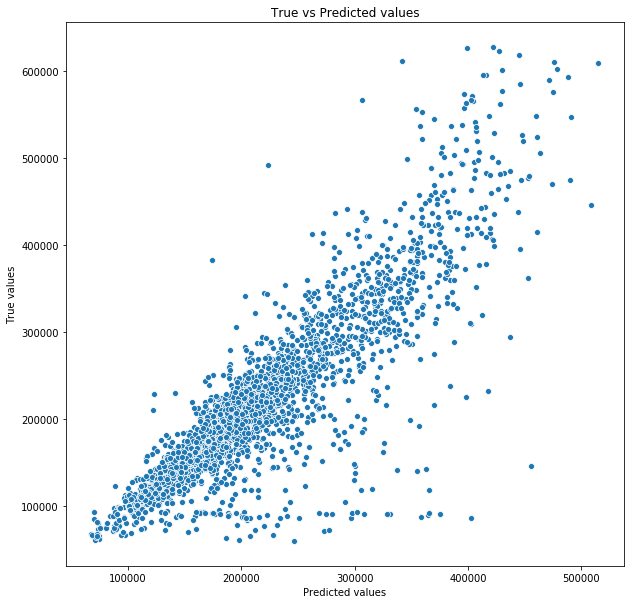

In [163]:
y_test_preds = rfr.predict(X_test)
evaluate_preds(y_test['Price'], y_test_preds)

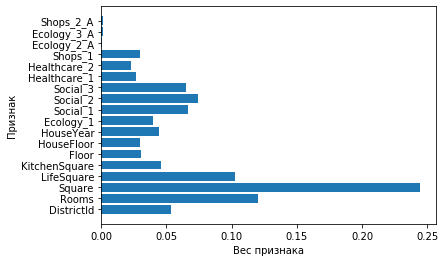

In [164]:
plt.barh(feature_names, rfr.feature_importances_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

In [167]:
gbr = GradientBoostingRegressor(
    max_depth=5, 
    max_features=4, 
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=400, 
    random_state=42)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.767
MAE:	27190.424
MSE:	2055675680.775


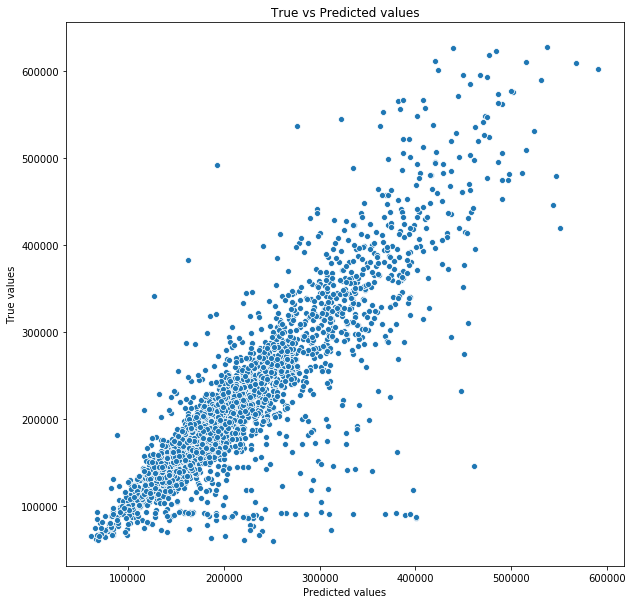

In [169]:
y_test_preds = gbr.predict(X_test)
evaluate_preds(y_test['Price'], y_test_preds)

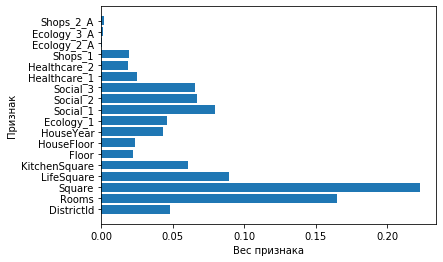

In [170]:
plt.barh(feature_names, gbr.feature_importances_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

plt.show()

##### Вывод:
Таким образом можно предположить, что влияние некотрых признаков не оказывает значимого влияния на результаты предсказаний и имеет смысл исследовать возможность предсказывать без них.

#### Подготовка списка наиболее важных признаков 

In [165]:
feature_names_for_stand = [
    feature
    for feature, weight in zip(feature_names, rfr.feature_importances_.flatten())
    if np.abs(weight) > 0.01
]

print(feature_names_for_stand)

['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Healthcare_2', 'Shops_1']


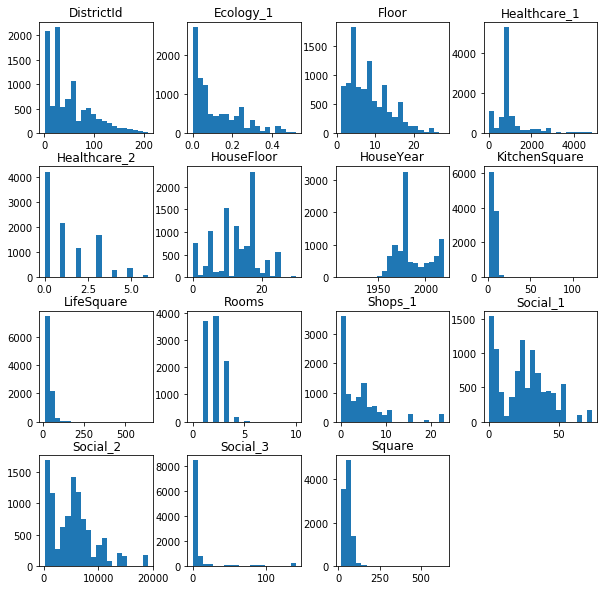

In [166]:
df_num_features = train[feature_names_for_stand]

df_num_features.hist(figsize=(10,10), bins=20, grid=False);

## Подготовка и обучение модели
### Оценка эффективности только для значимых признаков

In [125]:
X = train[feature_names_for_stand]
y = train[['Price']]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 14 columns):
DistrictId       9990 non-null float64
Rooms            9990 non-null int32
Square           9990 non-null float64
LifeSquare       9990 non-null float64
KitchenSquare    9990 non-null float64
Floor            9990 non-null float64
HouseFloor       9990 non-null float64
HouseYear        9990 non-null float64
Ecology_1        9990 non-null float64
Social_1         9990 non-null int64
Social_2         9990 non-null int64
Social_3         9990 non-null int64
Healthcare_1     9990 non-null int32
Shops_1          9990 non-null int64
dtypes: float64(8), int32(2), int64(4)
memory usage: 1014.7 KB


In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [127]:
rfr = RandomForestRegressor(n_estimators=1000, max_depth=400, random_state=42)

In [128]:
%%time

rfr.fit(X_train, y_train.values[:, 0])

Wall time: 56.9 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=400,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

R2:	0.752
MAE:	27905.978
MSE:	2188626831.577


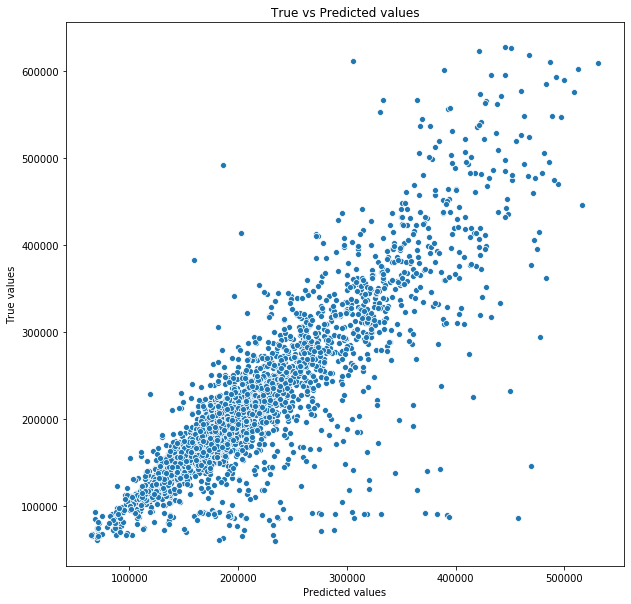

In [129]:
y_test_preds = rfr.predict(X_test)
evaluate_preds(y_test['Price'], y_test_preds)

In [ ]:
gbr = GradientBoostingRegressor(
    max_depth=5, 
    max_features=4, 
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=400, 
    random_state=42)

gbr.fit(X_train, y_train)

In [ ]:
y_test_preds = gbr.predict(X_test)
evaluate_preds(y_test, y_test_preds)

###### ВЫВОД: 
Таким образом, по критерию R2, эфективность для моделей, построенным по всем признакам и по наиболее значимым, примерно схожая. 

### Оценка эффективности подхода кластеризации для всех столбцов

In [83]:
df_features = train.copy()
df_features.drop({'Price'}, axis=1, inplace=True)

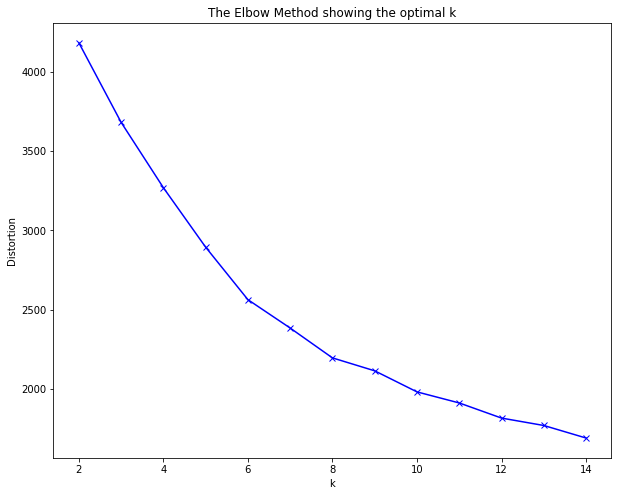

In [84]:
apply_elbow_method(df_features)

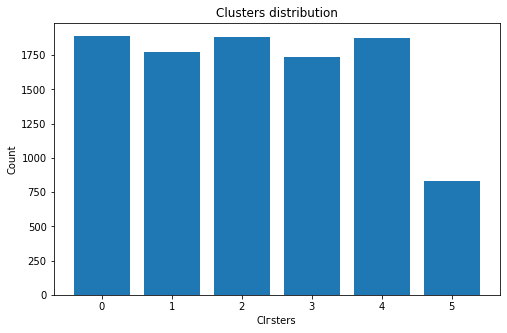

In [85]:
kmeans = KMeans(n_clusters=6, max_iter=100, random_state=42)

labels_train_6 = kmeans.fit_predict(df_features)
labels_train_6 = pd.Series(labels_train_6, name='clusters_6')

unique, counts = np.unique(labels_train_6, return_counts=True)
display_clusters_distribution(unique, counts)

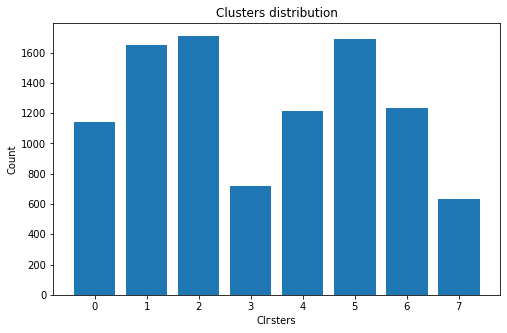

In [86]:
kmeans = KMeans(n_clusters=8, max_iter=100, random_state=42)

labels_train_8 = kmeans.fit_predict(df_features)
labels_train_8 = pd.Series(labels_train_8, name='clusters_8')

unique, counts = np.unique(labels_train_8, return_counts=True)
display_clusters_distribution(unique, counts)

In [87]:
components_3d = reduce_dims_to_3D_space_with_PCA(df_features)

In [89]:
clusters_6_dummies = pd.get_dummies(labels_train_6, drop_first=True, prefix='clusters_6')
clusters_8_dummies = pd.get_dummies(labels_train_8, drop_first=True, prefix='clusters_8')

df_ext = pd.concat([df_features, components_3d, clusters_6_dummies, clusters_8_dummies, train[['Price']]], axis=1)

pd.options.display.max_columns=200

In [90]:
df_ext.to_pickle("./test_ext.pkl")

In [115]:
df_ext = pd.read_pickle("./test_ext.pkl")

In [91]:
X = df_ext.iloc[:, :-1]
y = df_ext.iloc[:, -1]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [95]:
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()

In [96]:
lab_enc = LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

##### Поэкспериментируем с RandomForestRegressor

In [97]:
param_grid = {
    'max_depth': [100, 200],
    'max_features': [4], #np.arange(2, 5),
    'min_samples_leaf': [1], #np.arange(1, 3),
    'min_samples_split': [3],
    'n_estimators': [1000]
}

grid_search = GridSearchCV(estimator = rfr, 
                           param_grid = param_grid, 
                           cv = 3
                          )

In [98]:
%%time

grid_search.fit(X_train, y_train_encoded)

Wall time: 1min 23s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [100, 200], 'max_f

In [99]:
print(grid_search.best_params_)

{'max_depth': 200, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 1000}


In [100]:
rfr = RandomForestRegressor(
    bootstrap=True, 
    max_depth=100, 
    max_features=4, 
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=1000, 
    random_state=42)

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

R2:	0.735
MAE:	29318.726
MSE:	2344463956.533


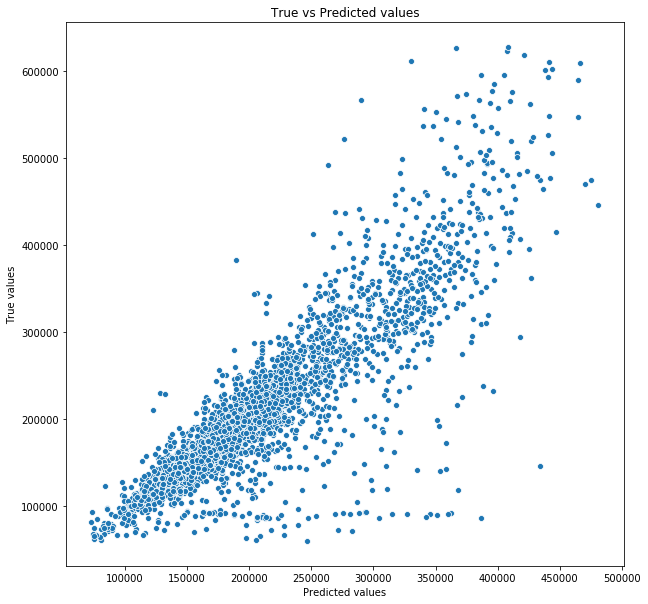

In [101]:
y_test_preds = rfr.predict(X_test)
evaluate_preds(y_test, y_test_preds)

##### Поэкспериментируем с GradientBoostingRegressor

In [102]:
param_grid = {
    'max_depth': np.arange(4, 7),
    'max_features': np.arange(3, 5),
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [400, 600]
}

grid_search = GridSearchCV(estimator = gbr, 
                           param_grid = param_grid, 
                           cv = 3
                          )

In [103]:
%%time

grid_search.fit(X_train, y_train_encoded)

Wall time: 4min 24s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [104]:
print(grid_search.best_params_)

{'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


In [105]:
gbr = GradientBoostingRegressor(
    max_depth=5, 
    max_features=4, 
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=400, 
    random_state=42)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=4, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.748
MAE:	28611.372
MSE:	2226964383.387


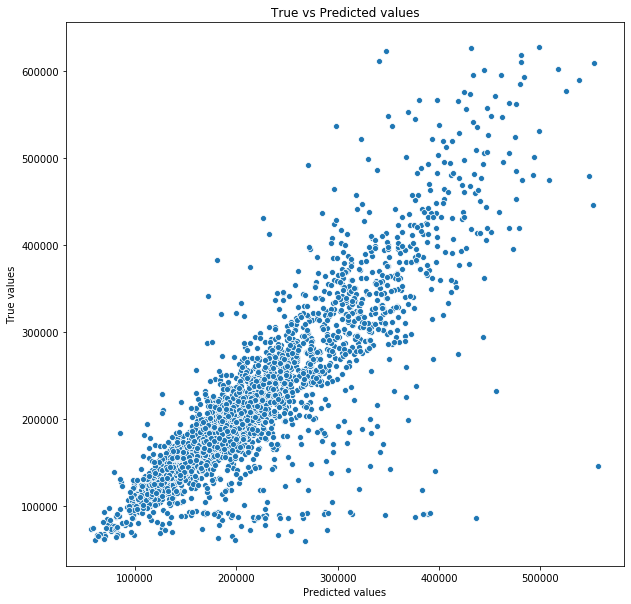

In [106]:
y_test_preds = gbr.predict(X_test)
evaluate_preds(y_test, y_test_preds)

### Оценка эффективности подхода кластеризации только для значимых столбцов

In [131]:
df_features = train[feature_names_for_stand]

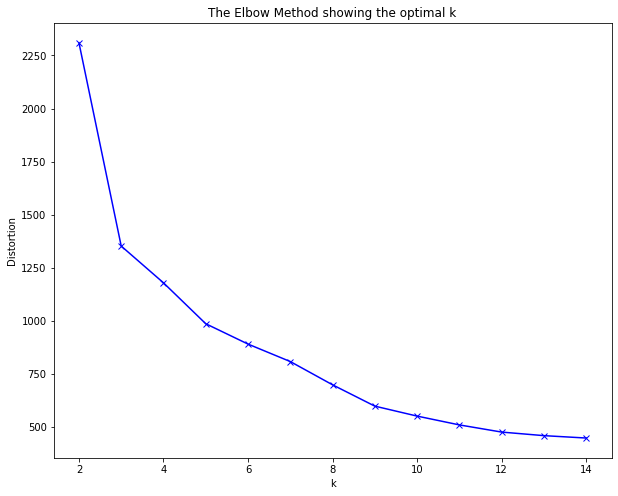

In [132]:
apply_elbow_method(df_features)

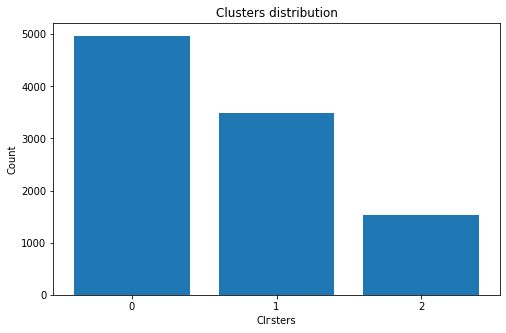

In [133]:
kmeans = KMeans(n_clusters=3, max_iter=100, random_state=42)

labels_train_3 = kmeans.fit_predict(df_features)
labels_train_3 = pd.Series(labels_train_3, name='clusters_3')

unique, counts = np.unique(labels_train_3, return_counts=True)
display_clusters_distribution(unique, counts)

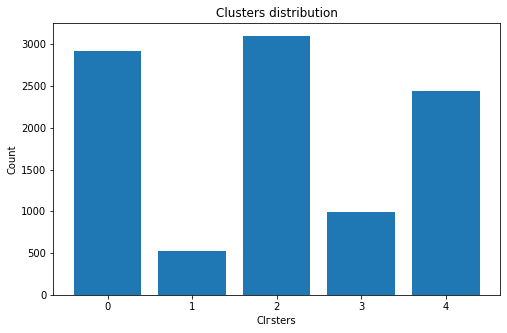

In [134]:
kmeans = KMeans(n_clusters=5, max_iter=100, random_state=42)

labels_train_5 = kmeans.fit_predict(df_features)
labels_train_5 = pd.Series(labels_train_5, name='clusters_5')

unique, counts = np.unique(labels_train_5, return_counts=True)
display_clusters_distribution(unique, counts)

In [135]:
components_3d = reduce_dims_to_3D_space_with_PCA(df_features)

In [137]:
clusters_3_dummies = pd.get_dummies(labels_train_3, drop_first=True, prefix='clusters_3')
clusters_5_dummies = pd.get_dummies(labels_train_5, drop_first=True, prefix='clusters_5')

df_ext = pd.concat([df_features, components_3d, clusters_3_dummies, clusters_5_dummies, train[['Price']]], axis=1)

pd.options.display.max_columns=200

In [90]:
df_ext.to_pickle("./test_ext.pkl")

In [115]:
df_ext = pd.read_pickle("./test_ext.pkl")

In [138]:
X = df_ext.iloc[:, :-1]
y = df_ext.iloc[:, -1]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [140]:
rfr = RandomForestRegressor()
gbr = GradientBoostingRegressor()

In [141]:
lab_enc = LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)

##### Поэкспериментируем с RandomForestRegressor

In [144]:
param_grid = {
    'max_depth': [100, 200],
    'max_features': np.arange(2, 5),
    'min_samples_leaf': np.arange(1, 3),
    'min_samples_split': [3],
    'n_estimators': [1000]
}

grid_search = GridSearchCV(estimator = rfr, 
                           param_grid = param_grid, 
                           cv = 3
                          )

In [145]:
%%time

grid_search.fit(X_train, y_train_encoded)

Wall time: 6min 11s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [100, 200],
      

In [146]:
print(grid_search.best_params_)

{'max_depth': 100, 'max_features': 4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 1000}


In [147]:
rfr = RandomForestRegressor(
    bootstrap=True, 
    max_depth=100, 
    max_features=4, 
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=1000, 
    random_state=42)

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=100,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

R2:	0.752
MAE:	28027.07
MSE:	2186990474.622


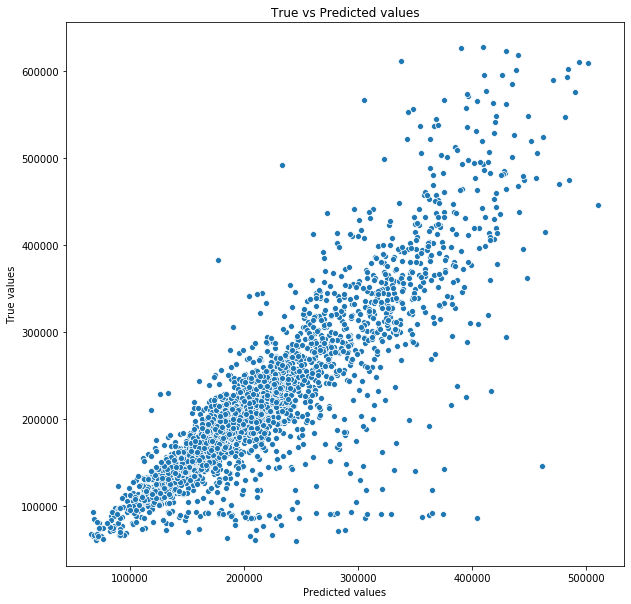

In [148]:
y_test_preds = rfr.predict(X_test)
evaluate_preds(y_test, y_test_preds)

##### Поэкспериментируем с GradientBoostingRegressor

In [149]:
param_grid = {
    'max_depth': np.arange(4, 7),
    'max_features': np.arange(3, 5),
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 3],
    'n_estimators': [400, 600]
}

grid_search = GridSearchCV(estimator = gbr, 
                           param_grid = param_grid, 
                           cv = 3
                          )

In [150]:
%%time

grid_search.fit(X_train, y_train_encoded)

Wall time: 4min 51s


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter...
                             

In [151]:
print(grid_search.best_params_)

{'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 400}


In [152]:
gbr = GradientBoostingRegressor(
    max_depth=4, 
    max_features=3, 
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=400, 
    random_state=42)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.765
MAE:	27459.538
MSE:	2074917497.141


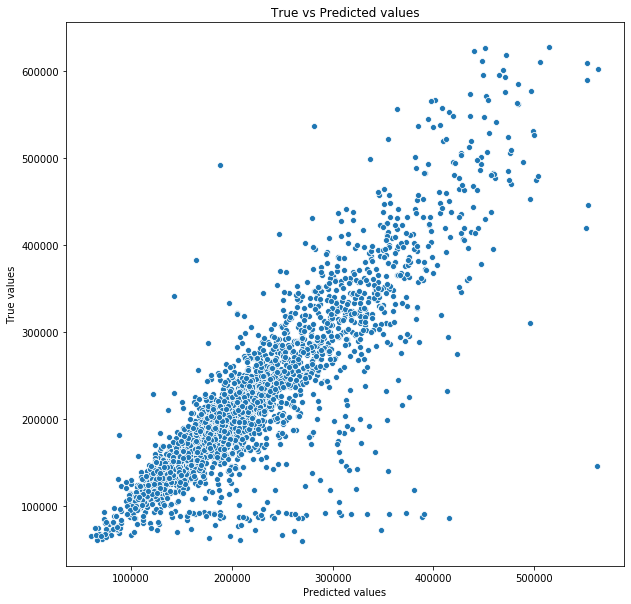

In [153]:
y_test_preds = gbr.predict(X_test)
evaluate_preds(y_test, y_test_preds)

## Предсказание модели

далее - по аналогии с обучением - очищаю признаки и применяю модель GradientBoostingRegressor, показавшую лучшую метрику

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [171]:
parameters = [{
    'n_estimators': [10, 15],
    'max_features': np.arange(3, 5),
    'max_depth': np.arange(4, 7)
}]

grid_search = GridSearchCV(
    estimator = RandomForestClassifier(random_state=100),
    param_grid = parameters,
    scoring = 'roc_auc',
    cv=3
)

In [172]:
%%time

grid_search.fit(X_train, y_train_encoded)

ValueError: n_splits=3 cannot be greater than the number of members in each class.

Вот, собссно, как-то так...